### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

This fitting uses a Photonic Quantum Neural network.

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://pennylane.ai/
>
> https://discuss.pennylane.ai/t/function-fitting/1025/5

In [1]:
#pip3 install pennylane pennylane-sf pennylane-lightning

In [2]:
#pip3 install pennylane pennylane-sf pennylane-lightning pennylane-qiskit 

In [3]:
import pennylane as pnl
pnl.__version__

'0.25.0'

In [4]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer #, GradientDescentOptimizer, RMSPropOptimizer
from pennylane import numpy as np
#from pennylane.templates.layers import CVNeuralNetLayers
#import strawberryfields as sf

import pandas as pd
import matplotlib.pyplot as plt
import time

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [5]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [6]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [7]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

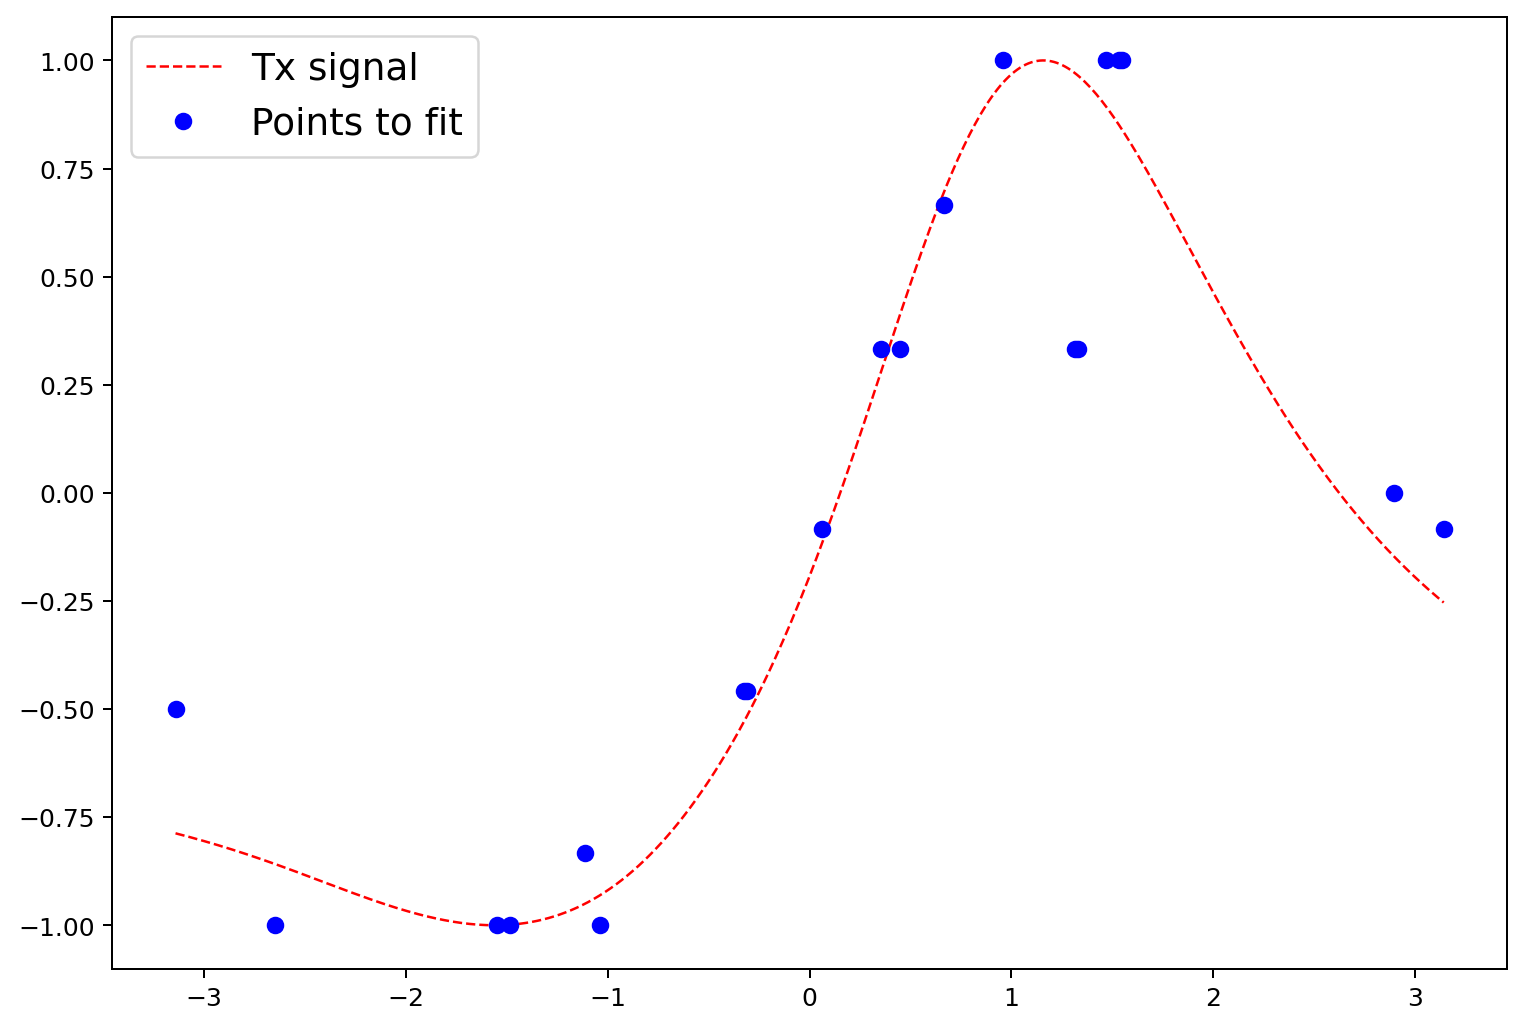

In [8]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = np.array(sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False)))
#print(indices)

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

X = X_[indices].reshape(-1,1)
y = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

y = detrend(y)

X = scale(X)
y = scale(y, -1, 1)

X_ = scale(X_)
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(X, y, "bo", label = 'Points to fit')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [9]:
X_data =  X.numpy()[:, 0].reshape(-1, 1)
y_data = y.numpy()[:, 0].reshape(-1, 1)

########  parameters #############
n_qubits = 2 ## num. of qubit
n_layers = 2 # num of q_layers

dev = qml.device("lightning.qubit", wires=n_qubits, shots=None) # define a device
# Note: lightning.qubits is faster but "pip install PennyLane-Lightning" is required.

# Initial circuit parameters
var_init = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits, 3))

# Definition of a device
@qml.qnode(dev, diff_method='adjoint')
def quantum_neural_net(var, x):
    # Data encoding and variational ansatz
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(var, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))
        
def square_loss(desired, predictions):
    loss = 0
    for l, p in zip(desired, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(desired)
    return loss

def cost(var, features, desired):
    preds = [quantum_neural_net(var, x) for x in features]
    return square_loss(desired, preds)

opt = qml.AdamOptimizer(0.05)

hist_cost = []
var = var_init
for it in range(50):
    t1 = time.time() 
    var, _cost = opt.step_and_cost(lambda v: cost(v, X_data, y_data), var)
    t2 = time.time() 
    elapsed_time = t2-t1
    print("Iter:"+str(it)+", cost="+str(_cost.numpy()))
    #print(f"Time：{elapsed_time}")
    hist_cost.append(_cost)

Iter:0, cost=[0.87116624]
Iter:1, cost=[0.73761252]
Iter:2, cost=[0.61475429]
Iter:3, cost=[0.50562161]
Iter:4, cost=[0.41193621]
Iter:5, cost=[0.33396436]
Iter:6, cost=[0.27049417]
Iter:7, cost=[0.21923665]
Iter:8, cost=[0.17790265]
Iter:9, cost=[0.14503525]
Iter:10, cost=[0.11979739]
Iter:11, cost=[0.10144382]
Iter:12, cost=[0.08904056]
Iter:13, cost=[0.08143716]
Iter:14, cost=[0.07738115]
Iter:15, cost=[0.07567813]
Iter:16, cost=[0.0753256]
Iter:17, cost=[0.07558209]
Iter:18, cost=[0.0759688]
Iter:19, cost=[0.07622624]
Iter:20, cost=[0.07625329]
Iter:21, cost=[0.07604908]
Iter:22, cost=[0.07566689]
Iter:23, cost=[0.07518186]
Iter:24, cost=[0.0746701]
Iter:25, cost=[0.07419616]
Iter:26, cost=[0.07380602]
Iter:27, cost=[0.07352392]
Iter:28, cost=[0.07335206]
Iter:29, cost=[0.07327299]
Iter:30, cost=[0.07325483]
Iter:31, cost=[0.07325878]
Iter:32, cost=[0.07324787]
Iter:33, cost=[0.07319512]
Iter:34, cost=[0.073089]
Iter:35, cost=[0.07293497]
Iter:36, cost=[0.07275289]
Iter:37, cost=[0

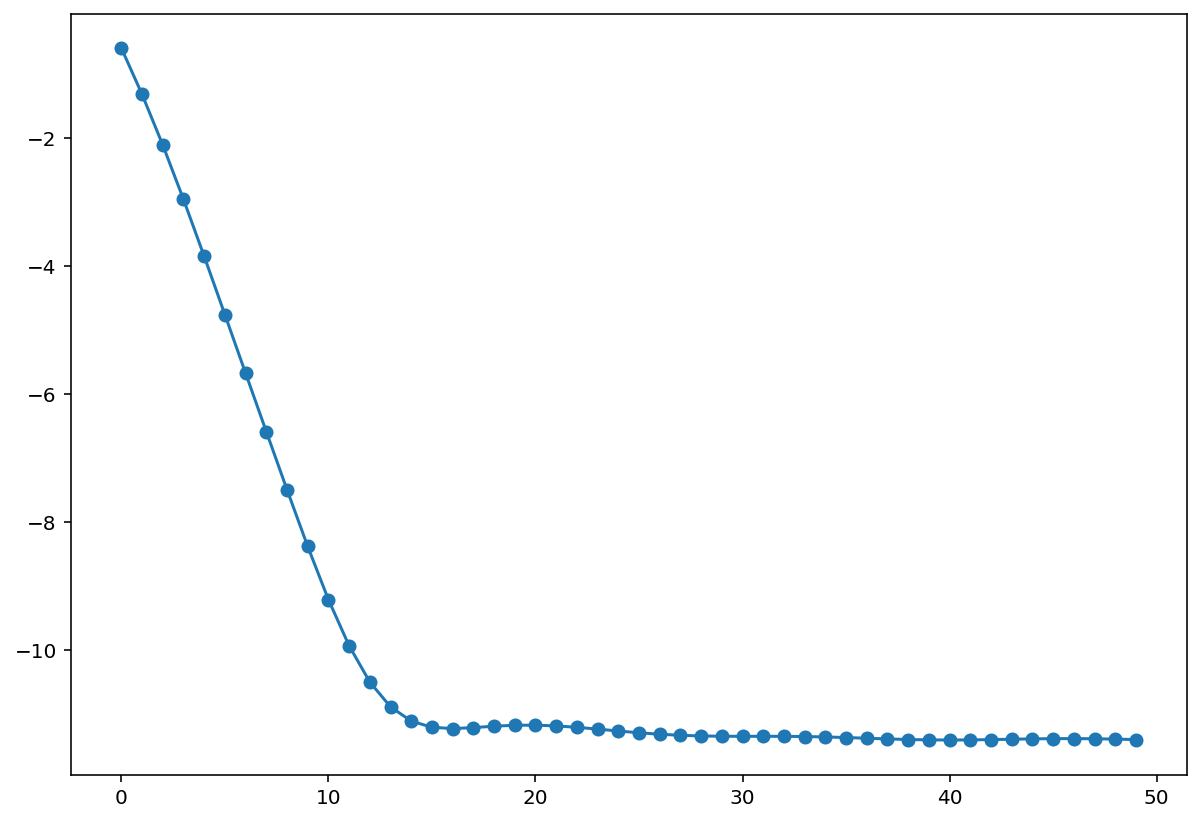

In [10]:
plt.plot(10 * np.log10(hist_cost), 'o-')

In [11]:
X_pred = X_.numpy()[:,0].reshape(-1, 1)
y_predict = [quantum_neural_net(var, x_) for x_ in X_pred]
y_predict_smooth = smooth(y_predict)

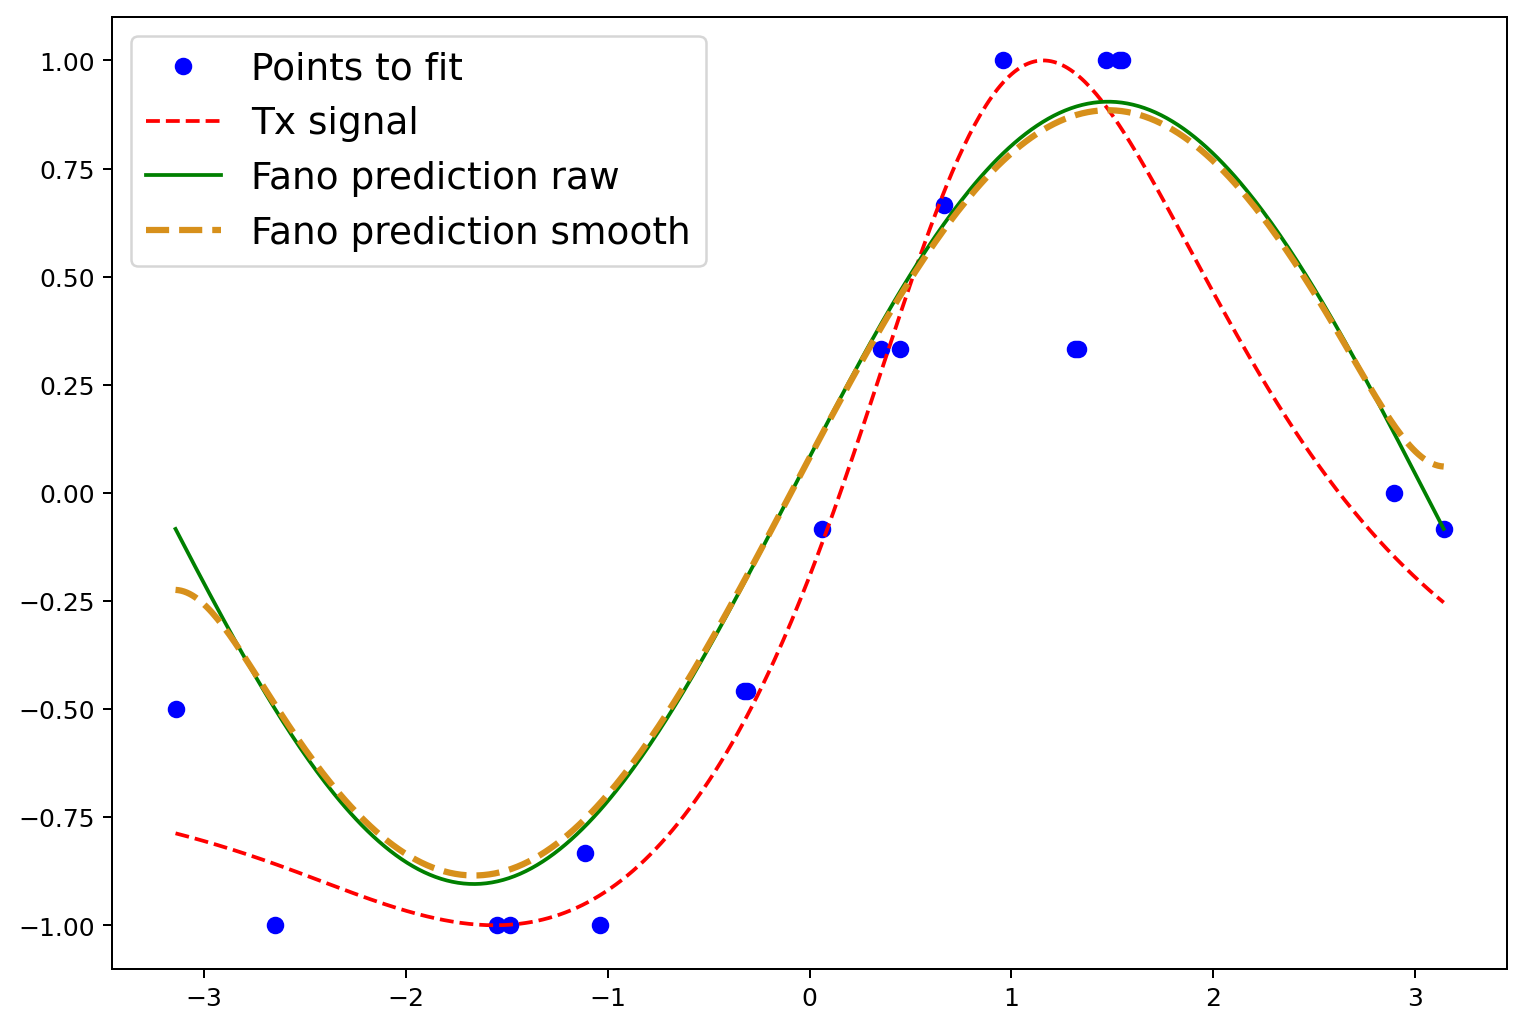

In [12]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict, "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth, "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [13]:
print("Score: %.10f" % r2_score(y_, y_predict))   

Score: 0.8522651132


In [14]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright